In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import neuraltoolkit as ntk
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
import copy
#import mgktools as mgk
import musclebeachtools as mbt
#Need to add musclebeachtools to path

import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import mountainlab_pytools as mtlp

import tkinter as tk
from tkinter import filedialog

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib
#import matplotlib.backends.backend_pdf as mpdf
import seaborn as sns
import json
import time
import os
import os.path as op
import glob
import re
import scipy
import sys
import boto3


%matplotlib inline
plt.rcParams.update({"text.usetex":False})

# This needs to be adjusted/generalized

In [3]:
sys.path.append('C:\\Users\\Ash\\github\\musclebeachtools_hlab')

In [4]:
def spiketimes_to_spikewords(spiketimes, startime, stoptime, binsize, binarize): 
    ### ARGUMENTS
    #spiketimes - list of spiketime arrays where each element of list is for a different neuron (e.g. the output of getspikes())
    #startime,stoptime - bounds of time to convert to spikewords (in seconds)
    #binsize - size of bin in milliseconds
    #binarize - '1' to convert to 0's and 1's, '0' to keep as histogram counts
    ### RETURNS
    #array of spikewords with each column as a cell and each rows as time in bins 
    
    #get sec_time to bin conversion factor
    #startime in bins
    startime_ms = startime * 1000
    stoptime_ms = stoptime * 1000
    binrange = np.arange(start = startime_ms, stop = stoptime_ms+1, step = binsize)
    n_cells = len(spiketimes)

    spikewords_array = np.zeros([n_cells, binrange.shape[0]-1])
    for i in range(n_cells):
        spiketimes_cell = spiketimes[i] * 1000 #spiketimes in seconds * 1000 msec/sec
        counts, bins = np.histogram(spiketimes_cell, bins = binrange)
        if binarize == 1:
            #binarize the counts
            counts[counts>0] = 1
        # print(counts.astype(np.int))
        spikewords_array[i,:] = counts
    return(spikewords_array.astype(np.int8).T)

# List/select from s3, use boto

In [6]:
!aws --endpoint https://s3.nautilus.optiputer.net s3 ls s3://braingeneers/ephys/2020-07-06-e-MGK-76-2614-PreDrug/mgk_results/

2020-08-19 21:41:19    2060999 rasters.zip
2020-08-20 00:31:51   84538420 spikeintf_well_A1_chgroup_1.zip
2020-08-20 00:31:07   65328019 spikeintf_well_A1_chgroup_2.zip
2020-08-20 00:19:03   66966749 spikeintf_well_A1_chgroup_3.zip
2020-08-20 00:39:14   92616758 spikeintf_well_A2_chgroup_1.zip
2020-08-20 00:17:49   95908691 spikeintf_well_A2_chgroup_2.zip
2020-08-20 00:19:29   70411390 spikeintf_well_A2_chgroup_3.zip
2020-08-20 00:31:50   99927074 spikeintf_well_A2_chgroup_4.zip
2020-08-20 00:18:44  106986646 spikeintf_well_A2_chgroup_5.zip
2020-08-20 00:21:54   80408305 spikeintf_well_A2_chgroup_6.zip
2020-08-20 00:21:12   36064377 spikeintf_well_A3_chgroup_1.zip
2020-08-20 00:23:42   80976232 spikeintf_well_B1_chgroup_1.zip
2020-08-20 00:24:48  110808978 spikeintf_well_B1_chgroup_2.zip
2020-08-20 00:26:42   92682115 spikeintf_well_B1_chgroup_3.zip
2020-08-20 00:27:02   83125882 spikeintf_well_B1_chgroup_4.zip
2020-08-20 00:30:13  118010892 spikeintf_well_B1_chgroup_5.zip
2020-08-20 0

In [31]:
# import boto3

# s3 = boto3.resource('s3')
# bucket = s3.Bucket('https://braingeneers.s3.us-west-1.amazonaws.com')
# for obj in bucket.objects.all():
#     print(obj.key, obj.last_modified)

In [32]:

# session = boto3.Session(profile_name='default',config=my_config)


# s3 = session.resource('s3')
# my_bucket = s3.Bucket('braingeneers/')

# s3client = boto3.client('s3',config=my_config)

# response = s3client.list_buckets()


# print('Existing buckets:')
# for bucket in response['Buckets']:
#     print(f'  {bucket["Name"]}')

In [33]:
# s3.list_buckets()

# for my_bucket_object in my_bucket.objects.all():
#     print(my_bucket_object)

In [34]:
# for key in s3client.list_objects(Bucket='bucket_name')['Contents']:
#     print(key['Key'])

# When downloaded locally: 
Load in data

s3.ServiceResource()

# Change wd to results dir from download

In [39]:
print(os.getcwd())
os.chdir('../../../Desktop/matt/root/data/2020-07-06-e-MGK-76-2614-PreDrug/results')
print('Changed to: ',os.getcwd())


C:\Users\Ash\github\braingeneerspy\tests
Changed to:  C:\Users\Ash\Desktop\matt\root\data\2020-07-06-e-MGK-76-2614-PreDrug\results


In [40]:
# I hate this, fix?
sys.modules['musclebeachtools_hlab'] = sys.modules['musclebeachtools']
sys.modules['musclebeachtools_hlab.musclebeachtools'] = sys.modules['musclebeachtools']

# Load in data for well A1 channel

In [164]:
well='A1ch'
c=0
n = None
for f in sorted(glob.glob(well+'*')):
    n_temp = np.load(f+'/spikeintf/outputs/neurons_group0.npy', allow_pickle=True)
    n_amp = mbt.mbt_neurons.load_spike_amplitudes(n_temp, f+'/spikeintf/outputs/amplitudes0.npy')
    
    n_prb = open(glob.glob(f+'/spikeintf/inputs/*probefile.prb')[0])
    lines = n_prb.readlines()
    real_chans = []
    s = lines[5]
    n = s.split()
    for chan in range(1,len(n)):
        #print(n[chan])
        result = re.search('c_(.*)\'', n[chan])
        real_chans.append(int(result.group(1)))
        
    for i in range(len(n_temp)):
        chan = n_temp[i].peak_channel
        #print(chan)
        n_temp[i].peak_channel = real_chans[chan]
    
    n_prb.close()
    
    if c == 0:
        nrn = n_temp
    else:
        nrn = np.append(nrn, n_temp)
    
    c = c+1
    
n = nrn

2020-11-02 22:46:56,156 - musclebeachtools_hlab.musclebeachtools.mbt_neurons - INFO - Updating spike_amplitude
2020-11-02 22:46:56,160 - musclebeachtools_hlab.musclebeachtools.mbt_neurons - INFO - Updating spike_amplitude
2020-11-02 22:46:56,163 - musclebeachtools_hlab.musclebeachtools.mbt_neurons - INFO - Updating spike_amplitude


In [165]:
n

array(['Neuron(sp_cluster, sp_times, quality, meanwaveform,meanwaveformspline, peak_channel)',
       'Neuron(sp_cluster, sp_times, quality, meanwaveform,meanwaveformspline, peak_channel)',
       'Neuron(sp_cluster, sp_times, quality, meanwaveform,meanwaveformspline, peak_channel)',
       'Neuron(sp_cluster, sp_times, quality, meanwaveform,meanwaveformspline, peak_channel)',
       'Neuron(sp_cluster, sp_times, quality, meanwaveform,meanwaveformspline, peak_channel)',
       'Neuron(sp_cluster, sp_times, quality, meanwaveform,meanwaveformspline, peak_channel)',
       'Neuron(sp_cluster, sp_times, quality, meanwaveform,meanwaveformspline, peak_channel)',
       'Neuron(sp_cluster, sp_times, quality, meanwaveform,meanwaveformspline, peak_channel)',
       'Neuron(sp_cluster, sp_times, quality, meanwaveform,meanwaveformspline, peak_channel)',
       'Neuron(sp_cluster, sp_times, quality, meanwaveform,meanwaveformspline, peak_channel)',
       'Neuron(sp_cluster, sp_times, quality, mean

In [45]:
for k in n[0].__dict__.keys():
    print(k)

clust_idx
spike_time
quality
waveform
waveforms
peak_channel
fs
start_time
end_time
waveform_tetrodes
on_times
off_times
key
cell_type
mean_amplitude
spike_amplitude


IndexError: index 28 is out of bounds for axis 0 with size 28

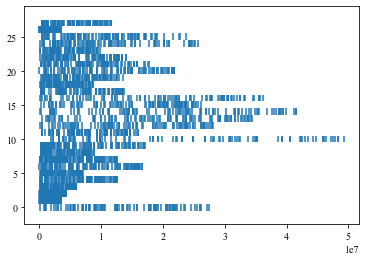

In [166]:
spikes = [n[1].spike_time,n[2].spike_time]
# plt.eventplot(n[1].spike_time[:100])
# plt.eventplot(n[2].spike_time[:100],lineoffsets=3)
# plt.eventplot(n[3].spike_time[:100],lineoffsets=5)
plt.eventplot(n[4].spike_time[:100],lineoffsets=7)
for i in range(100):
    plt.eventplot(n[i].spike_time[:100],lineoffsets=i)

In [52]:
from scipy  import sparse
from scipy  import signal

from scipy.sparse import csr_matrix

In [170]:
spike_list = []
for i in range(len(n)):
    spike_list.append(n[i].spike_time)

In [226]:
def load_spike_times(spike_times,fs=1,window_size=10000000,max_neurons=10):
    '''Take in list of list of spike times
    spike_times[0] -> list of spike times for neuron 0
    spike_times[0][10] -> neuron zero at timestep 10
    
    outputs dense array of size (neurons, timesteps)
    '''
        
    spike_times = copy.deepcopy(spike_times)
    
    t_max = 0
    for neuron in spike_times:
        cur_t_max = max(neuron)
        if cur_t_max > t_max:
            t_max = cur_t_max
            
            
    t_max = np.min([t_max+1,window_size])
    #Create
    neuron_num = min(len(spike_times),max_neurons)
    spike_dense = np.zeros((neuron_num,t_max))


    for neuron_index, waveform in enumerate(spike_times):
        if neuron_index >= max_neurons:
            break
        for timestep in waveform:
            if timestep >= t_max:
                break
            spike_dense[neuron_index,timestep] = 1

    return spike_dense


In [233]:
spike_dense = load_spike_times(spike_list)
neu.spikes = spike_dense
neu.neurons = spike_dense.shape[0]
n = None

MemoryError: Unable to allocate 763. MiB for an array with shape (10, 10000000) and data type float64

In [234]:
neu.spike_correlation()

MemoryError: Unable to allocate 7.45 GiB for an array with shape (10, 10, 10000000) and data type float64

In [116]:
rat = (280000000000000/(6590*584876602))
d = rat*100*28000*1000000
d/10000000000

20340.723689209928

In [159]:
n[1000].spike_time

IndexError: index 1000 is out of bounds for axis 0 with size 28

array([  11524,   20450,   27704,   28977,  104576,  109195,  136633,
        167017,  247861,  263201,  329277,  369408,  382535,  385149,
        434920,  526413,  537898,  548445,  635387,  703211,  733563,
        868588,  949564, 1020799, 1026539, 1032596, 1107148, 1121996,
       1122603, 1206701, 1225443, 1257317, 1285423, 1286545, 1299697,
       1312105, 1315346, 1326692, 1362921, 1369658, 1399473, 1400727,
       1450318, 1450546, 1462506, 1611380, 1618651, 1656799, 1660188,
       1718234, 1731235, 1757949, 1786780, 1798148, 1805600, 1936752,
       1961613, 2020005, 2036810, 2052011, 2158641, 2220750, 2347806,
       2486839, 2560881, 2571897, 2586134, 2605786, 2666517, 2667285,
       2683745, 2707932, 2712158, 2743393, 2758081, 2772133, 2777617,
       2793835, 2877838, 2943230, 2955479, 3022628, 3080515, 3082263,
       3108552, 3169075, 3182499, 3231644, 3233908, 3257982, 3305743,
       3381991, 3390259, 3394913, 3429524, 3433073, 3460453, 3521486,
       3556731, 3564

In [202]:
from braingeneers import neuron

In [203]:
neuron

<module 'braingeneers.neuron' from 'C:\\Users\\Ash\\Anaconda3\\envs\\bgr\\lib\\site-packages\\braingeneers\\neuron.py'>

In [210]:
from braingeneers import neuron

In [214]:
n = neuron.Neuron('test')

In [215]:
n.load_spike_times(spike_times)

AttributeError: 'Neuron' object has no attribute 'load_spike_times'

In [216]:
from ..braingeneerspy.braingeneers import neuron

ImportError: attempted relative import with no known parent package

In [219]:

import braingeneers.neuron

In [223]:
neu = neuron.Neuron('test')